In [1]:
%pip install --upgrade pip 
%pip install -U langchain  
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph  
%pip install -qU "langchain[mistralai]" 
%pip install -qU langchain-huggingface
%pip install sentence-transformers
%pip install -qU langchain-core
%pip install -qU langchain_community pypdf pillow
%pip install hf_xet
%pip install -qU langchain-chroma

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.72.1 requires protobuf<7.0.0,>=6.30.0, but you have protobuf 5.29.5 which is incompatible.


INDEXING

In [15]:
import getpass
import os
os.environ["ANONYMIZED_TELEMETRY"] = "FALSE"
from langchain.chat_models import init_chat_model
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document
from typing import NamedTuple, Tuple
from langgraph.graph import START, StateGraph
from dotenv import load_dotenv,find_dotenv

In [3]:
# Langsmith e os e getpass para lidar com as chaves de api do .env
load_dotenv(find_dotenv())  # Encontrar e carregar o documento .env que contém as chaves de api

os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter API key fot langsmith: ") # Se a chave de api não for encontrada o usuário deve inserir

In [4]:
# Modelo de chat utilizado foi o mistral small, modelo open source da mistral ai
if not os.environ.get("MISTRAL_API_KEY"):
  os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter API key for Mistral AI: ") # Se a chave não for encontrada o usuário deve inserir

llm = init_chat_model("mistral-small-2503", model_provider = "mistralai") # Modelo de chat utilizado para a aplicação

In [5]:
# Embedding model open-source do huggingface
embeddings = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")

In [6]:
# Vector store chroma, database por diretório
vector_store = Chroma( 
    collection_name="exames_extraidos",
    embedding_function=embeddings,
    persist_directory="C:/JupyterNotebook/RAG/rag_chroma_db",  # Caminho do diretório que vai conter os embeddings
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [7]:
# Carregando documentos em pdf por diretório
directory_path = (
    "C:/JupyterNotebook/RAG/RAG_exames"
)
loader = PyPDFDirectoryLoader("RAG_exames/")

docs = loader.load() # Carrega os documentos que o RAG vai usar

In [8]:
# Dividindo os documento em chunks para fazer os embeddings
text_splitter = RecursiveCharacterTextSplitter(  # Divide os documentos em chunks para ser feito o embedding e guardar na base de dados
    chunk_size=1000,  # tamanho do chunk (caracteres)
    chunk_overlap=200,  # overlap do chunk (caracteres)
    add_start_index=True,  # acompanhar o indice do documento original
)
all_splits = text_splitter.split_documents(docs)

In [9]:
# Storing documents
document_ids = vector_store.add_documents(documents=all_splits) # Coloca os documentos no vetor

INICIO DO RETRIEVAL E GENERATION

In [10]:
# Prompt
template = """Você é um especialista em análise de relatórios de mamografia. Por favor, leia o relatório quando indicado e extraia as seguintes informações:
Cisto:
- Presente ou Ausente
- Localização e tamanho do cisto
Nódulo:
- Presente ou Ausente
- Localização e tamanho do nódulo
Calcificação:
- Presente ou Ausente
- Localização e tamanho da calcificação
Microcalcificação:
- Presente ou Ausente
- Localização e tamanho da microcalcificação
BI-RADS: [valor]
Outras citações a avaliar: [observações adicionais relevantes]

Caso não encontre alguma informação que se encaixe, coloque [sem referência no texto].

Diretrizes de Interpretação

Diferenciação entre Nódulo e Cisto:

Se um achado é identificado inicialmente como "nódulo" na mamografia, mas confirmado como "cisto" no ultrassom, classifique apenas como CISTO (presente).
Nódulos são estruturas sólidas; cistos são estruturas predominantemente líquidas.
Complexos sólido-císticos devem ser reportados em ambas categorias (nódulo E cisto).


Priorização de Achados Múltiplos:

Quando houver múltiplos cistos/nódulos, reporte TODOS, priorizando:
a) Achados classificados como suspeitos pelo relatório
b) Achados de maior tamanho
c) Achados com características atípicas mencionadas


Diferenciação entre Calcificações e Microcalcificações:

Calcificações: estruturas maiores, geralmente descritas como "grosseiras", "distróficas", "vasculares"
Microcalcificações: estruturas menores, frequentemente descritas como "puntiformes", "pleomórficas", "lineares", "agrupadas", "em cluster"
Se o relatório mencionar "microcalcificações", classifique especificamente como microcalcificações
Se mencionar apenas "calcificações", classifique como calcificações.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [11]:
# estado para o langgraph
class State(NamedTuple):  # Informações que o pipeline vai carregar de um nó para o outro. Facilita leitura, manutenção e evita bugs
    question: str  # Pergunta feita pelo usuário
    context: Tuple[Document, ...] # Contexto recuperado da base de dados
    answer: str  # Resposta gerada pela llm

In [12]:
# Funções do rag
def retrieve(state: State):  # Recupera nos documentos dados parecidos com os inputados
    retrieved_docs = vector_store.similarity_search(state.question) # Faz uma comparação da pergunta com os dados no vetor e recupera os mais parecidos
    return State(
        question=state.question, 
        context=tuple(retrieved_docs), # Usamos tuple em vez de lista por ser um estrutura imutável, o que facilita o uso do LangGraph
        answer=state.answer
    )

def generate(state: State):  # Gera uma resposta com a adição das informações encontradas no vetor
    docs_content = "\n\n".join(doc.page_content for doc in state.context)
    messages = custom_rag_prompt.invoke({"question": state.question, "context": docs_content})
    response = llm.invoke(messages)
    return State(
        question=state.question,
        context=state.context,
        answer=response.content
    )

In [13]:
# O LangGraph vai garantir que cada etapa (nó) do fluxo receba e devolva um objeto do tipo State
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [14]:
state_inicial = State(  # Estado incial da aplicação necessário por causa do uso de tuple
    question="""Faça a extração das característica do seguinte exame mamográfico.

MAMOGRAFIA DIGITAL DR* BILATERAL

Indicação clínica: 69 anos. Rotina. Antecedente de neoplasia mamária.

Exame com MAMÓGRAFO DIGITAL nas incidências craniocaudal e mediolateral oblíqua acrescido de incidências em ambas projeções obtidas com manobras de deslocamento posterior dos implantes mamários.

Status pós cirurgia conservadora da mama esquerda.
Parênquima mamário heterogeneamente denso, o que reduz a sensibilidade da mamografia.
Alterações arquiteturais, relacionadas à mamoplastia.
Nódulo denso de contornos espiculados projetado no QSE da mama esquerda, associado a retração cutânea,
com correspondência ao ultrassom, maior em relação ao exame de 01/2024. Prosseguir com core biopsy.
Cisto oleoso na mama esquerda.
Calcificações esparsas.
Ausência de microcalcificações pleomórficas agrupadas ou ramificadas.
Implante bilateral, sem sinais de roturas extracapsulares.
Linfonodo axilar, de aspecto reacional.

ACR-BIRADS® categoria 5.""",
    context=tuple([]),
    answer=" "
)

response = graph.invoke(state_inicial)
print(response["answer"])

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


### Extração das Características do Exame Mamográfico

**Cisto:**
- **Presente ou Ausente:** Presente
- **Localização e tamanho do cisto:** Cisto oleoso na mama esquerda (tamanho não especificado)

**Nódulo:**
- **Presente ou Ausente:** Presente
- **Localização e tamanho do nódulo:** Nódulo denso de contornos espiculados projetado no quadrante súpero-externo (QSE) da mama esquerda (tamanho não especificado)

**Calcificação:**
- **Presente ou Ausente:** Presente
- **Localização e tamanho da calcificação:** Calcificações esparsas (localização e tamanho não especificados)

**Microcalcificação:**
- **Presente ou Ausente:** Ausente
- **Localização e tamanho da microcalcificação:** [sem referência no texto]

**BI-RADS:** 5

**Outras citações a avaliar:**
- Alterações arquiteturais relacionadas à mamoplastia.
- Retração cutânea associada ao nódulo na mama esquerda.
- Implante bilateral sem sinais de roturas extracapsulares.
- Linfonodo axilar de aspecto reacional.
- Status pós cirurgia conser

In [16]:
# Contexto recuperado da base de dados do RAG
print(f'Context: {response["context"]}\n\n')

Context: (Document(id='351cfe28-d1b7-4666-9941-edce3f3d9ca6', metadata={'start_index': 0, 'total_pages': 1, 'moddate': '2025-06-28T19:39:27-03:00', 'page_label': '1', 'author': 'Hanna Reckziegel', 'creationdate': '2025-06-28T19:39:27-03:00', 'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'source': 'RAG_exames\\laudo_2_extraido.pdf', 'page': 0}, page_content='MAMOGRAFIA DIGITAL (DR) E ECOGRAFIA MAMÁRIA \nMamas simétricas constituídas predominantemente por tecido fibroglandular. \nAusência de microcalcificações suspeitas nas mamas. \nNo presente exame não há evidência de imagem com aspecto de nódulo ou \ncisto nas mamas. \nNão se observa imagem sugestiva de neoplasia. \nLinfonodos localizados nos prolongamentos axilares das mamas. \nA comparação com o exame anterior datado de 16.01.2017 demonstra não ter \ncorrido alteração significativa. \n \nBIRADS - 1 (exame normais). \n \nEXTRAÇÃO: \n \nCisto:  \n- Presente ou Ausente: ausente \n- Localização do cisto e tamanh

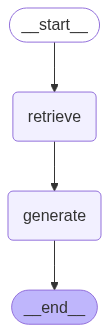

In [17]:
# LangGraph pra acompanhar o RAG
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))